In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

/Users/jiozhan/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jiozhan/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jiozhan/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jiozhan/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Background

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End- to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple- language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

# Model Architecture

In [59]:
class EncoderDecoder(nn.Module):
    """
    A standard encoder-decoder architecture.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder

![alt text](./5_TheAnnotatedTransformer_files/the-annotated-transformer_14_0.png)

# Encoder and Decoder Stacks

## Encoder
The encoder is composed of a stack of N = 6 identifal layers.

In [4]:
def clones(module, N):
    """
    Produce N identical layers
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [5]:
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection around each of the two sub-layers, followed by layer normalization.

In [49]:
class LayerNorm(nn.Module):
    """
    Construct the norm layer module
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean)/(std + self.eps) + self.b_2

That is, the output of each sub-layer is LayerNorm(x+Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout (cite) to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmodel=512.

In [50]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.

In [57]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-atn and feed forward
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer= clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        follow architecture for connections
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder

The decoder is also composed of a stack of N=6 identical layers.

In [52]:
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [53]:
class DecoderLayer(nn.Module):
    """
    Decoder is made of self-attn, src-attn, and feed forward
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        follow architecture for connections
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.



In [54]:
def subsequent_mask(size):
    """
    Mask out subsequent positions
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k = 1)
    return torch.from_numpy(subsequent_mask) == 0

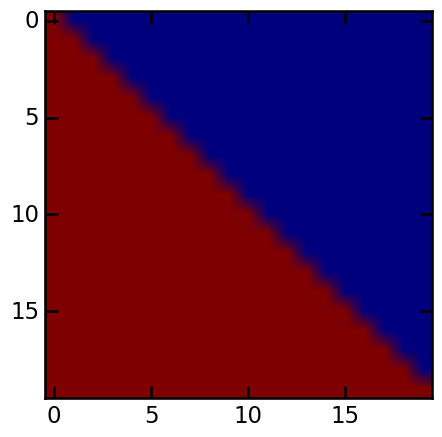

In [55]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0]);

## Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the query with all keys, divide each by dk‾‾√, and apply a softmax function to obtain the weights on the values.

![](5_TheAnnotatedTransformer_files/the-annotated-transformer_33_0.png)

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:

$$ \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V $$

In [13]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Compute scaled dot-product attention
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    ### mask?
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e10)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention (cite), and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of 1dk√. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of dk the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk (cite). We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, q⋅k=∑dki=1qiki, has mean 0 and variance dk.). To counteract this effect, we scale the dot products by 1dk√.

![](5_TheAnnotatedTransformer_files/the-annotated-transformer_38_0.png)

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$
    
Where the projections are parameter matrices WQi∈ℝdmodel×dk, WKi∈ℝdmodel×dk, WVi∈ℝdmodel×dv and WO∈ℝhdv×dmodel. In this work we employ h=8 parallel attention layers, or heads. For each of these we use dk=dv=dmodel/h=64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.



In [14]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        Take in model size and number of heads
        h: number of heads
        d_model: dimension of model (embedding dimension)
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Multi-head attention projections and connections"
        if mask is not None:
            # same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
                            for l,x in zip(self.linears, (query, key, value))]
        
        # 2) apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask,
                                dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways: 

1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.

# Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is dmodel=512, and the inner-layer has dimensionality dff=2048.

In [15]:
class PositionwiseFeedForward(nn.Module):
    """
    Implements FFN equation.
    d_model: embedding dimension 
    d_ff: hidden units
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to (cite). In the embedding layers, we multiply those weights by dmodel‾‾‾‾‾‾√.

In [47]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Position Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed (cite).

In this work, we use sine and cosine functions of different frequencies: PE(pos,2i)=sin(pos/100002i/dmodel)
PE(pos,2i+1)=cos(pos/100002i/dmodel) where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000⋅2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, PEpos+k can be represented as a linear function of PEpos.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of Pdrop=0.1.

In [17]:
class PositionalEncoding(nn.Module):
    """
    Position Embedding function implementation
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        # Compute the positional encodings once in log space
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad = False)
        return self.dropout(x)

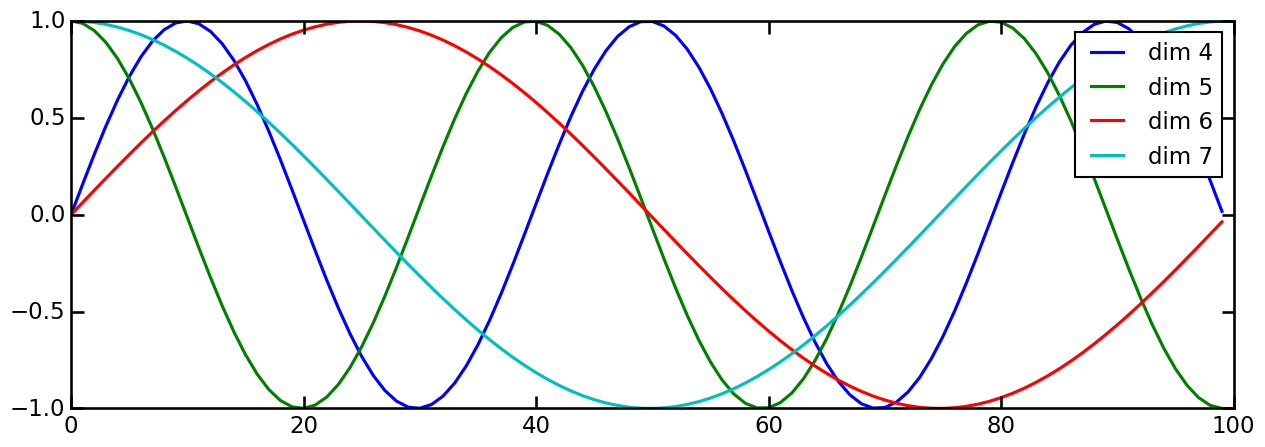

In [18]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

We also experimented with using learned positional embeddings (cite) instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

# Full Model

In [19]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct the model object from hyperparameters"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    # Initialize parameters with Glorot / fan_avg
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [20]:
# Small example model.
tmp_model = make_model(10, 10, 2)

# Training

here describes the training regime.

## batches and masking

In [40]:
class Batch:
    """
    Object for holding a batch of data with mask duing training
    """
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        """
        Create mask to hide padding and future words
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## Training Loop

In [42]:
def run_epoch(data_iter, model, loss_compute):
    """
    Stanford training and logging function
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Training Data and Batching


In [24]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Optimizer

In [25]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

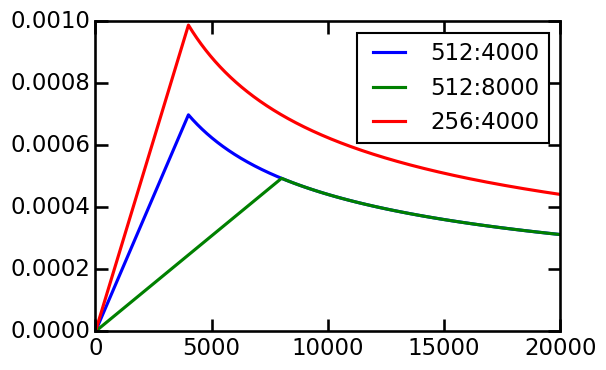

In [26]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"]);

## Regularization
### Label Smoothing

In [27]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/Users/jiozhan/anaconda3/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


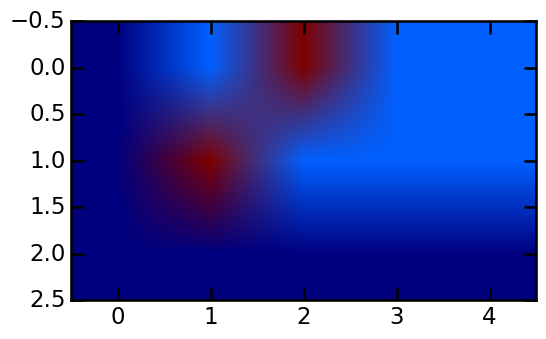

In [28]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist);

In [43]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)]);

/Users/jiozhan/anaconda3/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


RuntimeError: invalid argument 3: Index is supposed to be a vector at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.cpp:569

# First Example

In [44]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [61]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

In [62]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/Users/jiozhan/anaconda3/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


RuntimeError: invalid argument 3: Index is supposed to be a vector at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.cpp:569